In [183]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [184]:
#Убираем 0 
forest = pd.read_csv('forestfires.csv')
forest = forest[forest['area']>0]
forest

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
138,9,9,jul,tue,85.8,48.3,313.4,3.9,18.0,42,2.7,0.0,0.36
139,1,4,sep,tue,91.0,129.5,692.6,7.0,21.7,38,2.2,0.0,0.43
140,2,5,sep,mon,90.9,126.5,686.5,7.0,21.9,39,1.8,0.0,0.47
141,1,2,aug,wed,95.5,99.9,513.3,13.2,23.3,31,4.5,0.0,0.55
142,8,6,aug,fri,90.1,108.0,529.8,12.5,21.2,51,8.9,0.0,0.61
...,...,...,...,...,...,...,...,...,...,...,...,...,...
509,5,4,aug,fri,91.0,166.9,752.6,7.1,21.1,71,7.6,1.4,2.17
510,6,5,aug,fri,91.0,166.9,752.6,7.1,18.2,62,5.4,0.0,0.43
512,4,3,aug,sun,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,6.44
513,2,4,aug,sun,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,54.29


In [185]:
#создаем дамми для месяцев
forest = forest.join(pd.get_dummies(forest['month']))
forest.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,...,apr,aug,dec,feb,jul,jun,mar,may,oct,sep
138,9,9,jul,tue,85.8,48.3,313.4,3.9,18.0,42,...,0,0,0,0,1,0,0,0,0,0
139,1,4,sep,tue,91.0,129.5,692.6,7.0,21.7,38,...,0,0,0,0,0,0,0,0,0,1
140,2,5,sep,mon,90.9,126.5,686.5,7.0,21.9,39,...,0,0,0,0,0,0,0,0,0,1
141,1,2,aug,wed,95.5,99.9,513.3,13.2,23.3,31,...,0,1,0,0,0,0,0,0,0,0
142,8,6,aug,fri,90.1,108.0,529.8,12.5,21.2,51,...,0,1,0,0,0,0,0,0,0,0


In [186]:
#forest.drop(columns = 'month', inplace = True)
#Создаем переменную для выходных, так как человеческий фактор часто является причиной пожаров
forest['weekend'] = [1 if x in ['sat', 'sun'] else 0  for x in forest.day]

Text(0, 0.5, 'Частота')

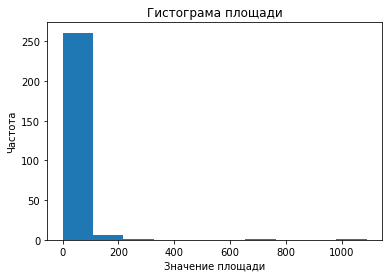

In [187]:
plt.hist(forest['area']);
plt.title('Гистограма площади')
plt.xlabel('Значение площади')
plt.ylabel("Частота")

Выглядит ненорально, стоит прологарифмировать

Text(0, 0.5, 'Частота')

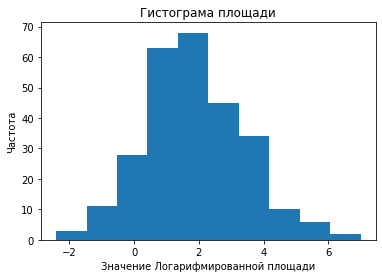

In [188]:
plt.hist(np.log(forest['area']));
plt.title('Гистограма площади')
plt.xlabel('Значение Логарифмированной площади')
plt.ylabel("Частота")

Теперь намного лучше!

In [189]:
forest[['FFMC', 'DMC', 'DC', 'ISI']].corr()

,FFMC,DMC,DC,ISI
FFMC,1.000000,0.480250,0.407638,0.704170
DMC,0.480250,1.000000,0.668926,0.329656
DC,0.407638,0.668926,1.000000,0.256826
ISI,0.704170,0.329656,0.256826,1.000000


Какие-то трудные и непонятные факторы, отвечающие за количество влаги в деревьях. Бахнем на них PCA, чтобы не тащить похожие факторы дальше, тем более у них зачастую положительная корреляция.

In [190]:
from sklearn.decomposition import IncrementalPCA as PCA
pca = PCA(n_components = 1)
for_fit = forest[['FFMC', 'DMC', 'DC', 'ISI']]
for_fit = pca.fit_transform(for_fit)


In [191]:
forest['PCA_4indicators'] = for_fit

In [192]:
forest.drop(['FFMC','DMC','DC', 'ISI'], axis= 1, inplace = True)

# 2

Давайте посмотрим, как можно использовать координаты

In [193]:
xx=[]
yy=[]
for x in np.unique(forest['X'].values):
    for y in np.unique(forest['Y'].values):
        xx.append(x)
        yy.append(y)

In [194]:
d = {'x':xx, 'y':yy}
for_scatter = pd.DataFrame(data= d)


In [195]:
area_scat = []
for _, row in for_scatter.iterrows():
    area_scat.append(forest.loc[(forest.X== row[0]) & (forest.Y==row[1])]['area'].mean())


In [196]:
for_scatter['area'] = area_scat
for_scatter.dropna(inplace = True)

Text(0, 0.5, 'Координата по У')

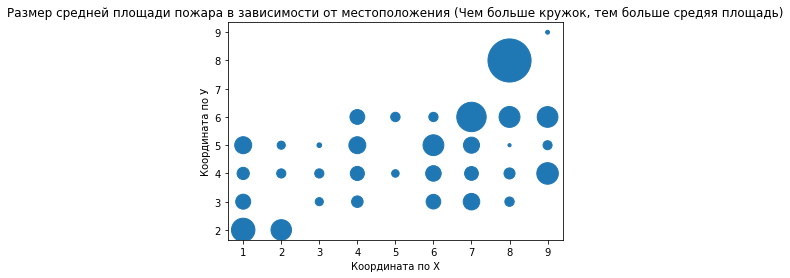

In [197]:
plt.scatter(for_scatter['x'], for_scatter['y'] , s = for_scatter['area'].values*10)
plt.title('Размер средней площади пожара в зависимости от местоположения (Чем больше кружок, тем больше средяя площадь)')
plt.xlabel('Координата по Х')
plt.ylabel('Координата по У')

Видно, что зависимость есть и она не линейная. Тогда создадим порядковую переменную (0, 1, 2), которая присуждается точкам  в зависимости от среднего размера сгоревшей площади на координатах. 

In [198]:
d = {}
for _,row in for_scatter.iterrows():
    d[(int(row[0]), int(row[1]))] = row[2]


In [199]:
categorical_for_location = []
for _, row in forest[['X', 'Y', 'area']].iterrows():
    if d[(row[0], row[1])] <15:
        categorical_for_location.append(0)
    elif d[(row[0], row[1])] <100:
        categorical_for_location.append(1)
    else:
        categorical_for_location.append(2)

In [200]:
forest['categorical_for_location'] = categorical_for_location
forest

,X,Y,month,day,temp,RH,wind,rain,area,apr,...,feb,jul,jun,mar,may,oct,sep,weekend,PCA_4indicators,categorical_for_location
138,9,9,jul,tue,18.0,42,2.7,0.0,0.36,0,...,0,1,0,0,0,0,0,0,-265.320971,0
139,1,4,sep,tue,21.7,38,2.2,0.0,0.43,0,...,0,0,0,0,0,0,1,0,122.370404,1
140,2,5,sep,mon,21.9,39,1.8,0.0,0.47,0,...,0,0,0,0,0,0,1,0,115.824104,0
141,1,2,aug,wed,23.3,31,4.5,0.0,0.55,0,...,0,0,0,0,0,0,0,0,-59.254211,1
142,8,6,aug,fri,21.2,51,8.9,0.0,0.61,0,...,0,0,0,0,0,0,0,0,-41.590414,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
509,5,4,aug,fri,21.1,71,7.6,1.4,2.17,0,...,0,0,0,0,0,0,0,0,188.197782,0
510,6,5,aug,fri,18.2,62,5.4,0.0,0.43,0,...,0,0,0,0,0,0,0,0,188.197782,1
512,4,3,aug,sun,27.8,32,2.7,0.0,6.44,0,...,0,0,0,0,0,0,0,1,82.424317,0
513,2,4,aug,sun,21.9,71,5.8,0.0,54.29,0,...,0,0,0,0,0,0,0,1,82.424317,0


In [201]:
forest.drop(columns=['X', 'Y','day'], inplace = True)

# Описание переменных

In [202]:
kolonki = ['temp', 'RH', 'wind', 'rain',  'weekend', 'PCA_4indicators', 'categorical_for_location']

In [203]:
d = {}
for var in kolonki:
    d[var] = (np.min(forest[var]), np.max(forest[var]), np.mean(forest[var]), np.median(forest[var]), np.var(forest[var]))

In [204]:
d

{'temp': (2.2, 33.3, 19.31111111111111, 20.1, 38.0440987654321),
 'RH': (15, 96, 43.733333333333334, 41.0, 226.5659259259259),
 'wind': (0.4, 9.4, 4.112962962962963, 4.0, 3.538461591220851),
 'rain': (0.0, 6.4, 0.02888888888888889, 0.0, 0.15812839506172846),
 'weekend': (0, 1, 0.3296296296296296, 0.0, 0.2209739368998628),
 'PCA_4indicators': (-566.6093656373988,
  317.0871381563081,
  5.0527483431829344e-14,
  92.81879180117872,
  54469.22241889868),
 'categorical_for_location': (0,
  2,
  0.6777777777777778,
  1.0,
  0.22580246913580249)}

Температура: Чем жарче-тем больше шанс пожара. Ожидаю положительный знак

Влажность (RH): Чем валжнее, тем больше влаги в деревьях, труднее гореть. Знак ожидаю отрицательный

Ветер: Чем быстрее ветер, тем быстрее огонь распространится с дерева на дерево. Ожидаю положительный знак

Дождь: Чем больше осадков, тем труднее гореть. Знак отрицательный. С другой стороны, если у нас нет 0 значений, то вероятно дождь в эти дни шел редко, следовательно может быть не значимм.

Выходные: Уже говорил про человеческий фактор. Знак положительный

PCA: Чем больше влаги в деревьях, тем труднее загореть. Знак отрицательный

Категориальная переменная по месту: Специально созданная руками переменная. Ожидаю положительный знак и большую объясняющую способность.


Гистограмы по каждому признаку


c:\python\python37\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
c:\python\python37\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
c:\python\python37\lib\site-packages\pandas\plotting\_matplotlib\tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
c:\python\python37\lib\site-packages\pandas\plotting\_matplotlib\tools.py:313: Matp

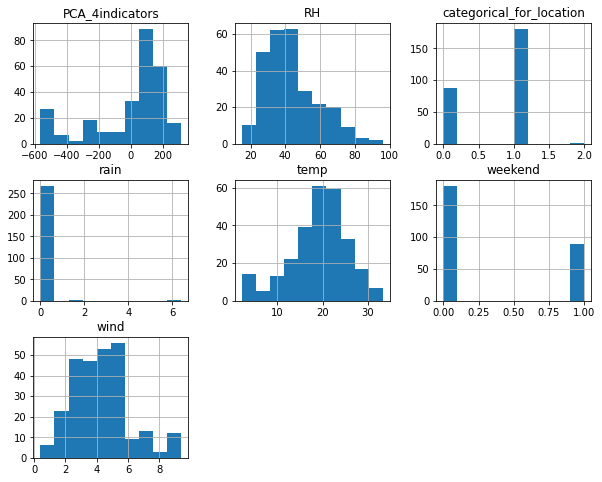

In [205]:
forest[kolonki].hist(figsize = (10,8));
print('Гистограмы по каждому признаку', flush = True)

In [206]:
kolonki

['temp',
 'RH',
 'wind',
 'rain',
 'weekend',
 'PCA_4indicators',
 'categorical_for_location']

Text(0, 0.5, 'Values of temp')

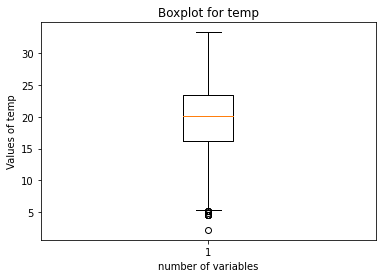

In [207]:
var = 'temp'
plt.boxplot(forest[var]);
plt.title('Boxplot for ' + var)
plt.xlabel('number of variables')
plt.ylabel('Values of ' + var)

Text(0, 0.5, 'Values of RH')

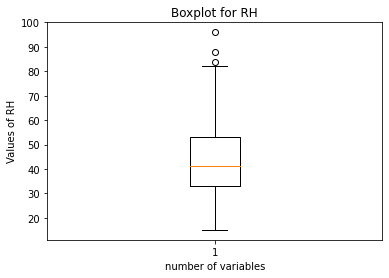

In [208]:
var = 'RH'
plt.boxplot(forest[var]);
plt.title('Boxplot for ' + var)
plt.xlabel('number of variables')
plt.ylabel('Values of ' + var)

Text(0, 0.5, 'Values of wind')

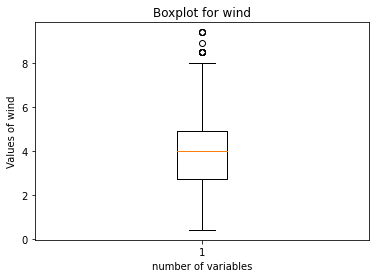

In [209]:
var = 'wind'
plt.boxplot(forest[var]);
plt.title('Boxplot for ' + var)
plt.xlabel('number of variables')
plt.ylabel('Values of ' + var)

Text(0, 0.5, 'Values of rain')

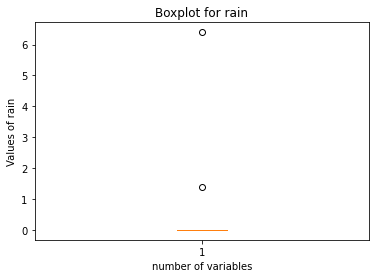

In [210]:
var = 'rain'
plt.boxplot(forest[var]);
plt.title('Boxplot for ' + var)
plt.xlabel('number of variables')
plt.ylabel('Values of ' + var)

Text(0, 0.5, 'Values of PCA_4indicators')

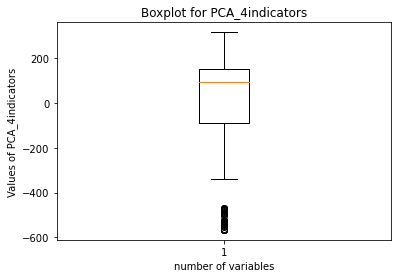

In [211]:
var = 'PCA_4indicators'
plt.boxplot(forest[var]);
plt.title('Boxplot for ' + var)
plt.xlabel('number of variables')
plt.ylabel('Values of ' + var)

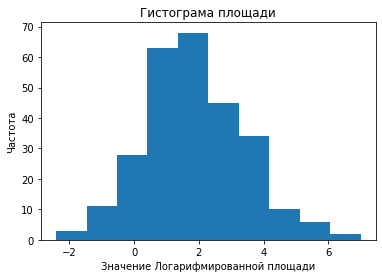

In [212]:
plt.hist(np.log(forest['area']));
plt.title('Гистограма площади')
plt.xlabel('Значение Логарифмированной площади')
plt.ylabel("Частота")
forest['log_area'] = np.log(forest.area)

In [213]:
forest.drop(columns='area', inplace = True)

# 3

In [214]:
import pandas as pd
import numpy as np
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [215]:
forest.head()

,month,temp,RH,wind,rain,apr,aug,dec,feb,jul,jun,mar,may,oct,sep,weekend,PCA_4indicators,categorical_for_location,log_area
138,jul,18.0,42,2.7,0.0,0,0,0,0,1,0,0,0,0,0,0,-265.320971,0,-1.021651
139,sep,21.7,38,2.2,0.0,0,0,0,0,0,0,0,0,0,1,0,122.370404,1,-0.843970
140,sep,21.9,39,1.8,0.0,0,0,0,0,0,0,0,0,0,1,0,115.824104,0,-0.755023
141,aug,23.3,31,4.5,0.0,0,1,0,0,0,0,0,0,0,0,0,-59.254211,1,-0.597837
142,aug,21.2,51,8.9,0.0,0,1,0,0,0,0,0,0,0,0,0,-41.590414,1,-0.494296


In [216]:
#считаем Vif с константой
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

X = add_constant(forest.drop(columns=['log_area', 'month']))
#X = forest.drop(columns=['log_area'])
pd.Series([variance_inflation_factor(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns)

c:\python\python37\lib\site-packages\numpy\core\fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
c:\python\python37\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
c:\python\python37\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


const                        0.000000
temp                         5.298193
RH                           2.455471
wind                         1.267820
rain                         1.081571
apr                               inf
aug                               inf
dec                               inf
feb                               inf
jul                               inf
jun                               inf
mar                               inf
may                               inf
oct                               inf
sep                               inf
weekend                      1.073087
PCA_4indicators             14.857770
categorical_for_location     1.097141
dtype: float64

In [217]:
#Уберем дамми для месяцев и константу. CN проверим дальше
forest = forest[['temp', 'RH', 'wind', 'rain', 'weekend', 'PCA_4indicators',
       'categorical_for_location', 'log_area']]

In [218]:
X = forest.drop(columns=['log_area'])
pd.Series([variance_inflation_factor(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns)

temp                        5.200746
RH                          6.317320
wind                        5.407426
rain                        1.017517
weekend                     1.549592
PCA_4indicators             1.241700
categorical_for_location    2.802685
dtype: float64

# 4

In [219]:
from statsmodels.regression.linear_model import OLS

In [220]:
#Строим регрессию Р квадрат - бомба
y = forest['log_area']
X = forest.drop(columns= 'log_area')
ols = OLS(y, X)
model = ols.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               log_area   R-squared (uncentered):                   0.618
Model:                            OLS   Adj. R-squared (uncentered):              0.608
Method:                 Least Squares   F-statistic:                              60.89
Date:                Sat, 20 Jun 2020   Prob (F-statistic):                    1.80e-51
Time:                        16:16:35   Log-Likelihood:                         -488.62
No. Observations:                 270   AIC:                                      991.2
Df Residuals:                     263   BIC:                                      1016.
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
temp                         0.0332      0.010      3.238      0.001       0.013       0.053
RH                           0.0018      0.005      0.373      0.710      -0.008       0.012
wind                         0.0897      0.047      1.913      0.057      -0.003       0.182
rain                        -0.0077      0.231     -0.034      0.973      -0.462       0.446
weekend                      0.4380      0.198      2.216      0.028       0.049       0.827
PCA_4indicators             -0.0004      0.000     -0.835      0.405      -0.001       0.000
categorical_for_location     0.8650      0.184      4.692      0.000       0.502       1.228
==============================================================================
Omnibus:                        0.204   Durbin-Watson:                   1.028
Prob(Omnibus):                  0.903   Jarque-Bera (JB):                0.072
Skew:                           0.027   Prob(JB):                        0.964
Kurtosis:                       3.060   Cond. No.                         595.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [221]:
model.condition_number

594.7970962147356

CN < 1000, так что все хорошо

Тест Jarque-Bera Не отвергает нулевую гипотезу о нормальности ошибок

Text(0, 0.5, 'Частота')

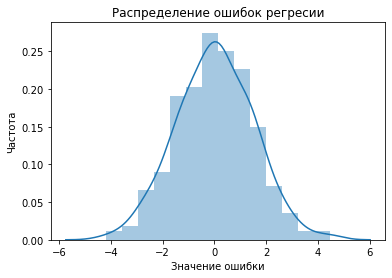

In [222]:
import seaborn as sns
import statsmodels.stats
sns.distplot(model.resid)
plt.title('Распределение ошибок регресии')
plt.xlabel('Значение ошибки')
plt.ylabel('Частота')

In [224]:
#Проверим на отличие ошибок от 0
print('p_value:',statsmodels.stats.weightstats.ztest(model.resid)[1]) 

p_value: 0.7921035331510281


Таким образом, ошибки нормально распределены и НЕ отличны от нуля. УРа, товарищи!

# Оценим коэффициенты бутстрепом

In [41]:
from tqdm import tqdm

In [42]:
coeffs = []

for i in tqdm(range(10000)):
    boots = forest.sample(30)
    y = boots['log_area']
    X = boots.drop(columns= 'log_area')
    ols_boot = OLS(y, X)
    model_boot = ols_boot.fit()
    coeffs.append(list(model_boot.params))

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:15<00:00, 644.48it/s]


In [225]:
from statsmodels.stats.weightstats import _tconfint_generic as conf_int
for i in range(7):
    print('Доверительный интервал для коэффициента при',boots.columns[i],np.mean(np.array(coeffs)[:, i])- 1.96*np.std(np.array(coeffs)[:, i])/np.sqrt(10000), np.mean(np.array(coeffs)[:, i])+ 1.96*np.std(np.array(coeffs)[:, i])/100 )

Доверительный интервал для коэффициента при temp 0.032462021023304824 0.03363898393725323
Доверительный интервал для коэффициента при RH 0.0015189005075074268 0.002116832468394941
Доверительный интервал для коэффициента при wind 0.08831041149629963 0.09406296158410764
Доверительный интервал для коэффициента при rain -0.05077951577704467 -0.04141073500022927
Доверительный интервал для коэффициента при weekend 0.43571741944613973 0.46139240667924786
Доверительный интервал для коэффициента при PCA_4indicators -0.00031029034680763357 -0.000261303974702199
Доверительный интервал для коэффициента при categorical_for_location 0.83605846290821 0.8578655615789021


# 5

In [44]:
forest.drop(columns = 'log_area').median().values

array([20.1      , 41.       ,  4.       ,  0.       ,  0.       ,
       92.8187918,  1.       ])

In [236]:
print('Точеный прогноз:', model.predict(forest.drop(columns = 'log_area').median().values))

Точеный прогноз: [1.93294371]


In [45]:
predictions = model.get_prediction(forest.drop(columns = 'log_area').median().values)
predictions.summary_frame(alpha=0.05)

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,1.932944,0.133014,1.671036,2.194852,-1.027623,4.893511


In [233]:
print('Интервал для среднего: ', (predictions.summary_frame().values[0][2], predictions.summary_frame().values[0][3]))

Интервал для среднего:  (1.6710357005925167, 2.1948517177167277)


# 6

Хоть гетероскедастичности и нет, все равно глянем на связь ошибок в квадрате и регрессоров

Ожидаю гетероскедастичность у температуры, так как с ее повышением площади могут расти экспоненциально

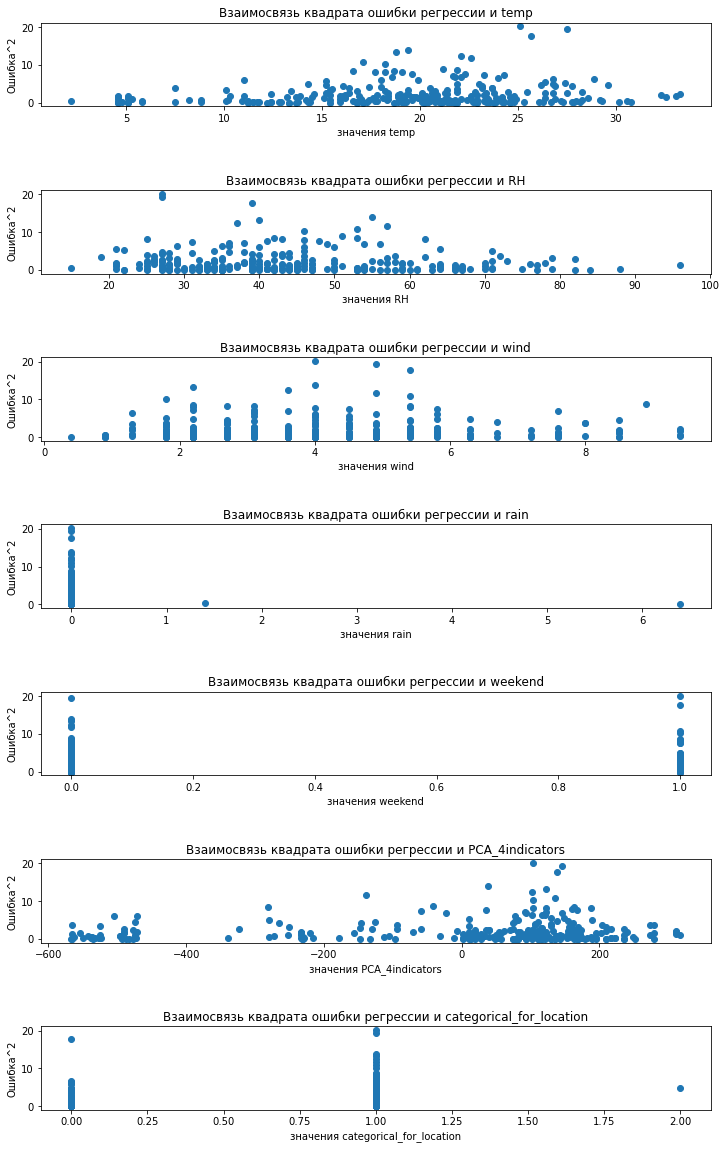

In [47]:
fig = plt.figure(figsize=(12,20))
for i in range(1,8):
    plt.subplot(7, 1, i)
    plt.scatter(forest.iloc[:,i-1], model.resid.values ** 2)
    plt.title('Взаимосвязь квадрата ошибки регрессии и ' +forest.columns[i-1])
    plt.xlabel('значения ' + forest.columns[i-1])
    plt.ylabel('Ошибка^2')
    plt.subplots_adjust(hspace = 1)

# 7

In [48]:
#Проведем тест Голдфелда-Кванта
import statsmodels.stats.api as sms
for i in [0,1,2,5]:
    test = sms.het_goldfeldquandt(model.resid, forest.iloc[:,i].values.reshape(-1,1))
    print('F statistic:', test[0], 'p-value:', test[1])

F statistic: 0.6866836575614262 p-value: 0.9848133203846033
F statistic: 0.6877307430580095 p-value: 0.9844761515581036
F statistic: 0.6869074907741777 p-value: 0.9847417370612868
F statistic: 0.6878941549794318 p-value: 0.9844230011404907


Все критические значения близки к 1, следовательно, гипотеза о гетероскедастичности НЕ подтвердилась

# 8

Строим обычную регрессию берем оттуда реальные ошибки в квадрате. И считаем что теоретические ошибки в квадрате пропорциональные реальным

$\beta_{HC0} = (X^TX)^{-1}X^T diag(e^2_1 ... e^2_n) X(X^tX)^{-1}$

In [52]:
from statsmodels.regression.linear_model import WLS
ols_hc0 = OLS(forest['log_area'], forest.drop(columns = 'log_area'))
model_ols_hc0 = ols_hc0.fit()
print(model_ols_hc0.get_robustcov_results(cov_type = "HC0").summary())

                                 OLS Regression Results                                
Dep. Variable:               log_area   R-squared (uncentered):                   0.618
Model:                            OLS   Adj. R-squared (uncentered):              0.608
Method:                 Least Squares   F-statistic:                              80.65
Date:                Sat, 20 Jun 2020   Prob (F-statistic):                    8.15e-62
Time:                        14:56:02   Log-Likelihood:                         -488.62
No. Observations:                 270   AIC:                                      991.2
Df Residuals:                     263   BIC:                                      1016.
Df Model:                           7                                                  
Covariance Type:                  HC0                                                  
                               coef    std err          t      P>|t|      [0.025      0.975]
---------------------------

$H = X(X^tX)^{-1} X^t$ 

$h_{ii} - H[i,i]$

$\beta_{HC3} = (X^TX)^{-1}X^T diag(e^2_1 ... e^2_n) X(X^tX)^{-1}$

In [53]:
from statsmodels.regression.linear_model import WLS
ols_hc3 = OLS(forest['log_area'], forest.drop(columns = 'log_area'))
model_ols_hc3 = ols_hc3.fit()
print(model_ols_hc3.get_robustcov_results(cov_type = "HC3").summary())

                                 OLS Regression Results                                
Dep. Variable:               log_area   R-squared (uncentered):                   0.618
Model:                            OLS   Adj. R-squared (uncentered):              0.608
Method:                 Least Squares   F-statistic:                              56.84
Date:                Sat, 20 Jun 2020   Prob (F-statistic):                    4.18e-49
Time:                        14:56:02   Log-Likelihood:                         -488.62
No. Observations:                 270   AIC:                                      991.2
Df Residuals:                     263   BIC:                                      1016.
Df Model:                           7                                                  
Covariance Type:                  HC3                                                  
                               coef    std err          t      P>|t|      [0.025      0.975]
---------------------------

# 9

In [54]:
from sklearn.decomposition import IncrementalPCA as PCA
pca = PCA(n_components = 2)
for_fit = forest.drop(columns= 'log_area')
for_fit = pca.fit_transform(for_fit)
pca.explained_variance_ratio_

array([0.99529573, 0.00427526])

In [55]:
pca_ols = OLS(forest['log_area'], for_fit)
model_pca_ols  = pca_ols .fit()
model_pca_ols .summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               log_area   R-squared (uncentered):                   0.001
Model:                            OLS   Adj. R-squared (uncentered):             -0.006
Method:                 Least Squares   F-statistic:                             0.1645
Date:                Sat, 20 Jun 2020   Prob (F-statistic):                       0.848
Time:                        14:56:02   Log-Likelihood:                         -618.52
No. Observations:                 270   AIC:                                      1241.
Df Residuals:                     268   BIC:                                      1248.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0002      0.001     -0.278      0.781      -0.001       0.001
x2            -0.0048      0.010     -0.501      0.616      -0.024       0.014
==============================================================================
Omnibus:                        4.721   Durbin-Watson:                   0.371
Prob(Omnibus):                  0.094   Jarque-Bera (JB):                4.389
Skew:                           0.288   Prob(JB):                        0.111
Kurtosis:                       3.244   Cond. No.                         15.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# 10


 $L = (2\pi\sigma^2)^{-N/2} exp(\frac{-(y-X\beta)^T(y-X\beta)}{2\sigma^2} )$

a)

In [58]:
y = forest['log_area']
X = forest.drop(columns='log_area').values
B = ((np.linalg.inv(X.T.dot(X))).dot(X.T)).dot(y)
Sigma = ((y - X.dot(B)).T).dot(y - X.dot(B))/270

b)

In [540]:
import numpy as np
def calc_grad(init = np.ones(7),  delta = 0.00001, dataframe = forest):
    y = dataframe['log_area'].values
    X = dataframe.drop(columns='log_area').values
    error_sqr = ((y - X.dot(init)).T).dot(y - X.dot(init))
    sigma = error_sqr/270
    #sigma = 1
    error_sqr_step = []
    for i in range(init.shape[0]):
        init_plus_delta = init.copy()
        init_plus_delta[i] += delta
        error_sqr_step.append(((y - X.dot(init_plus_delta)).T).dot(y - X.dot(init_plus_delta)))
                              
    error_sqr_step = np.array(error_sqr_step)
    grad_b = -1/(delta*2*sigma)*(error_sqr*np.ones(7) - error_sqr_step)
                              
    return grad_b

In [543]:
n_steps = 10000
i = 0
real_diff = 1
Beta_init = np.ones(7)
lrn_rate = 0.0005
while i < n_steps and real_diff > 0.0001:
    Beta_old = Beta_init.copy()
    Beta_init = Beta_init - lrn_rate * calc_grad(init = Beta_init)
    i+=1
    real_diff = ((Beta_old - Beta_init) ** 2).sum()

In [544]:
i

10000

In [545]:
real_diff

0.00028214169791246417

In [546]:
Beta_init

array([-0.08360157,  0.0364289 ,  0.1550954 ,  0.89972308,  0.92559045,
       -8.01968349,  0.94349426])

In [519]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               log_area   R-squared (uncentered):                   0.618
Model:                            OLS   Adj. R-squared (uncentered):              0.608
Method:                 Least Squares   F-statistic:                              60.89
Date:                Sat, 20 Jun 2020   Prob (F-statistic):                    1.80e-51
Time:                        17:55:27   Log-Likelihood:                         -488.62
No. Observations:                 270   AIC:                                      991.2
Df Residuals:                     263   BIC:                                      1016.
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
temp                         0.0332      0.010      3.238      0.001       0.013       0.053
RH                           0.0018      0.005      0.373      0.710      -0.008       0.012
wind                         0.0897      0.047      1.913      0.057      -0.003       0.182
rain                        -0.0077      0.231     -0.034      0.973      -0.462       0.446
weekend                      0.4380      0.198      2.216      0.028       0.049       0.827
PCA_4indicators             -0.0004      0.000     -0.835      0.405      -0.001       0.000
categorical_for_location     0.8650      0.184      4.692      0.000       0.502       1.228
==============================================================================
Omnibus:                        0.204   Durbin-Watson:                   1.028
Prob(Omnibus):                  0.903   Jarque-Bera (JB):                0.072
Skew:                           0.027   Prob(JB):                        0.964
Kurtosis:                       3.060   Cond. No.                         595.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Получилось че-то так себе